## Initial Data Cleaning ##

Collects and unifies primary and secondary school data where the anonymized student is present in both.

In [2]:
import csv
import os
import pandas as pd
import numpy as np

In [3]:
# Check files in the Raw Data folder
os.listdir('../Data/Raw')

['Avaluació_de_quart_d’Educació_Secundària_Obligatòria_20251112.csv',
 "Avaluació_de_sisè_d'educació_primària_20251112.csv",
 'Plantilles_del_personal_docent_dels_centres_públics_i_serveis_educatius_20251112.csv']

In [4]:
#csv_path = os.path.abspath("../Data/Raw/Avaluacio_de_quart_dEducació_Secundaria_Obligatoria_20251111.csv")

# GENERAL OPTION: Take the first file in the Raw Data folder
csv_path = os.path.join('../Data/Raw', os.listdir('../Data/Raw')[0])

secondary_data = []
with open(csv_path) as data: 
    reader = csv.reader(data)
    for row in reader:
        secondary_data.append(row)
    data.close()
df_S = pd.DataFrame(secondary_data)

# Second file in the Raw Data folder
csv_path = os.path.join('../Data/Raw', os.listdir('../Data/Raw')[1])
primary_data = []
with open(csv_path) as data: 
    reader = csv.reader(data)
    for row in reader:
        primary_data.append(row)
    data.close()
df_P = pd.DataFrame(primary_data)

In [5]:
df_P.columns = df_P.iloc[0]    # set first row as header
df_P = df_P[1:]                # drop the first row (since it's now the header)
df_P.reset_index(drop=True, inplace=True)

df_S.columns = df_S.iloc[0]    # set first row as header
df_S = df_S[1:]                # drop the first row (since it's now the header)
df_S.reset_index(drop=True, inplace=True)

In [6]:
df = pd.DataFrame({'CODI_ALUMNE': pd.concat([df_P['CODI_ALUMNE'], df_S['CODI_ALUMNE']]).unique()})
df['in_P'] = df['CODI_ALUMNE'].isin(df_P['CODI_ALUMNE']) 
df['in_S'] = df['CODI_ALUMNE'].isin(df_S['CODI_ALUMNE'])
matching = df[df['in_P'] & df['in_S']] 

# Keep only rows from df_P where CODI_ALUMNE exists in both
df_P_matching = df_P[df_P['CODI_ALUMNE'].isin(matching['CODI_ALUMNE'])].copy()
# Keep only rows from df_S where CODI_ALUMNE exists in both
df_S_matching = df_S[df_S['CODI_ALUMNE'].isin(matching['CODI_ALUMNE'])].copy()

df_P_matching.reset_index(drop=True, inplace=True)
df_S_matching.reset_index(drop=True, inplace=True)

In [7]:
common_cols = set(df_P_matching.columns) & set(df_S_matching.columns)

In [8]:
# List of required columns (from your message)
required_cols = [
    'ANY', 'ANY_NAIXEMENT', 'CODI_ALUMNE', 'GENERE', 'HÀBITAT',
    'MES_NAIXEMENT', 'NATURALESA', 'PANG', 'PANG_CO', 'PANG_EE',
    'PCAST', 'PCAST_CL', 'PCAST_EE', 'PCAT', 'PCAT_CL', 'PCAT_EE',
    'PFRAN', 'PFRAN_CO', 'PFRAN_EE', 'PMAT', 'PMAT_CR', 'PMAT_EFM', 'PMAT_NC'
]

df_P_clean = df_P.dropna(subset=required_cols).copy()
df_S_clean = df_S.dropna(subset=required_cols).copy()

common_ids = set(df_P_clean['CODI_ALUMNE']) & set(df_S_clean['CODI_ALUMNE'])
df_P_clean = df_P_clean[df_P_clean['CODI_ALUMNE'].isin(common_ids)]
df_S_clean = df_S_clean[df_S_clean['CODI_ALUMNE'].isin(common_ids)]

df_P_clean['snapshot'] = 'past'
df_S_clean['snapshot'] = 'present'

df_combined = pd.concat([df_P_clean, df_S_clean], ignore_index=True)

df_pivot = df_combined.pivot_table(
    index='CODI_ALUMNE',
    columns='snapshot',
    values=[col for col in required_cols if col != 'CODI_ALUMNE'],
    aggfunc='first'
)

In [9]:
df_pivot

0             ANY         ANY_NAIXEMENT         GENERE          \
snapshot     past present          past present   past present   
CODI_ALUMNE                                                      
             2018    2019          2005              H       D   
100028145    2018    2022          2005    2005      D       D   
1000332771   2016    2020          2004    2004      H       H   
1000343103   2016    2020          2004    2004      D       D   
1000354325   2016    2020          2004    2004      D       D   
...           ...     ...           ...     ...    ...     ...   
999005478    2016    2020          2004    2004      H       H   
999027032    2016    2020          2004    2004      H       H   
99949376     2016    2020          2004    2004      D       D   
99961597     2019    2023          2007    2007      H       H   
99983150     2018    2022          2006    2006      D       D   

0                      HÀBITAT                    MES_NAIXEMENT          ...  \
snapshot                  past            present          past present  ...   
CODI_ALUMNE                                                              ...   
                 Més de 100000      Més de 100000             1          ...   
100028145        Més de 100000      Més de 100000             7       7  ...   
1000332771   De 10001 a 100000  De 10001 a 100000             1       1  ...   
1000343103   De 10001 a 100000  De 10001 a 100000             1       1  ...   
1000354325   De 10001 a 100000  De 10001 a 100000            10      10  ...   
...                        ...                ...           ...     ...  ...   
999005478    De 10001 a 100000  De 10001 a 100000            11      11  ...   
999027032    De 10001 a 100000  De 10001 a 100000             9       9  ...   
99949376         Més de 100000      Més de 100000             7       7  ...   
99961597         Més de 100000      Més de 100000             7       7  ...   
99983150         Més de 100000      Més de 100000            10      10  ...   

0           PFRAN_EE           PMAT         PMAT_CR         PMAT_EFM          \
snapshot        past present   past present    past present     past present   
CODI_ALUMNE                                                                    
                              91,49          100,00            81,82           
100028145                     76,89   43,33   88,89   66,67    81,82   33.33   
1000332771                    91,59    79,8  100,00   88,89    91,67      70   
1000343103                    97,28   74,88  100,00   77,78   100,00      90   
1000354325                    94,20    97,5  100,00     100    83,43      90   
...              ...     ...    ...     ...     ...     ...      ...     ...   
999005478                     82,39   45,08   88,49   22,22    75,34      20   
999027032                     82,84   59,48   88,49   66,67    91,43      30   
99949376                      97,09   82,82  100,00   88,89    91,67      90   
99961597                      81,57   70,86   77,78    87,5    81,82    62.5   
99983150                      90,79   49,17   88,89   33,33    90,91   33.33   

0           PMAT_NC          
snapshot       past present  
CODI_ALUMNE                  
              92,86          
100028145     57,14       0  
1000332771    84,30   71,43  
1000343103    92,22   42,86  
1000354325   100,00     100  
...             ...     ...  
999005478     84,23   71,43  
999027032     69,41   85,71  
99949376     100,00   85,71  
99961597      85,71   55,56  
99983150      92,86    62,5  

[251748 rows x 44 columns]

In [10]:
matching.shape[0]

251748

In [11]:
common_cols

{'ANY',
 'ANY_NAIXEMENT',
 'CODI_ALUMNE',
 'GENERE',
 'HÀBITAT',
 'MES_NAIXEMENT',
 'NATURALESA',
 'PANG',
 'PANG_CO',
 'PANG_EE',
 'PCAST',
 'PCAST_CL',
 'PCAST_EE',
 'PCAT',
 'PCAT_CL',
 'PCAT_EE',
 'PFRAN',
 'PFRAN_CO',
 'PFRAN_EE',
 'PMAT',
 'PMAT_CR',
 'PMAT_EFM',
 'PMAT_NC'}

In [12]:
# One-to-one merge by CODI_ALUMNE eliminating duplicates

print("df_P_matching: files =", len(df_P_matching),
      " unique students =", df_P_matching['CODI_ALUMNE'].nunique())

print("df_S_matching: files =", len(df_S_matching),
      " unique students =", df_S_matching['CODI_ALUMNE'].nunique())

df_P_unique = df_P_matching.sort_values('CODI_ALUMNE').drop_duplicates('CODI_ALUMNE')
df_S_unique = df_S_matching.sort_values('CODI_ALUMNE').drop_duplicates('CODI_ALUMNE')

df_merged = pd.merge(
    df_P_unique,
    df_S_unique,
    on='CODI_ALUMNE',
    how='inner',           # only keep rows present in both
    suffixes=('_P', '_S'), # distinguish the two sets of columns
    validate='one_to_one'
)


df_P_matching: files = 700990  unique students = 251748
df_S_matching: files = 489510  unique students = 251748


### Test Adri
To access any column from primary or secondary, write the same column name with subindex _S or _P

In [13]:
print(df_merged.columns)

Index(['ANY_P', 'CODI_ALUMNE', 'PCAT_P', 'PCAT_CL_P', 'PCAT_EE_P', 'PCAST_P',
       'PCAST_CL_P', 'PCAST_EE_P', 'PMAT_P', 'PMAT_NC_P', 'PMAT_EFM_P',
       'PMAT_CR_P', 'PANG_P', 'PANG_CO_P', 'PANG_CE', 'PFRAN_P', 'PFRAN_CO_P',
       'PFRAN_CE', 'PANG_EE_P', 'PFRAN_EE_P', 'PCAT_CO', 'PCAST_CO', 'PMED',
       'PMED_COMP1', 'PMED_COMP2', 'PMED_COMP3', 'GENERE_P', 'MES_NAIXEMENT_P',
       'ANY_NAIXEMENT_P', 'AREA_TERRITORIAL', 'NATURALESA_P', 'HÀBITAT_P',
       'ANY_S', 'PCAT_S', 'PCAT_CL_S', 'PCAT_EE_S', 'PCAST_S', 'PCAST_CL_S',
       'PCAST_EE_S', 'PANG_S', 'PANG_CO_S', 'PANG_CL', 'PANG_EE_S', 'PFRAN_S',
       'PFRAN_CO_S', 'PFRAN_CL', 'PFRAN_EE_S', 'PMAT_S', 'PMAT_EFM_S',
       'PMAT_CR_S', 'PMAT_EST', 'PMAT_NC_S', 'PALE', 'PALE_CO', 'PALE_CL',
       'PALE_EE', 'PCIEN', 'PCIEN_COMP1', 'PCIEN_COMP2', 'PCIEN_COMP3',
       'PCIEN_COMP4', 'GENERE_S', 'MES_NAIXEMENT_S', 'ANY_NAIXEMENT_S',
       'NATURALESA_S', 'ÀREA TERRITORIAL', 'HÀBITAT_S'],
      dtype='object', name=0)


Columnes de notes trobades:
['PCAT_P', 'PCAT_CL_P', 'PCAT_EE_P', 'PCAST_P', 'PCAST_CL_P', 'PCAST_EE_P', 'PMAT_P', 'PMAT_NC_P', 'PMAT_EFM_P', 'PMAT_CR_P', 'PANG_P', 'PANG_CO_P', 'PANG_CE', 'PFRAN_P', 'PFRAN_CO_P', 'PFRAN_CE', 'PANG_EE_P', 'PFRAN_EE_P', 'PCAT_CO', 'PCAST_CO', 'PMED', 'PMED_COMP1', 'PMED_COMP2', 'PMED_COMP3', 'PCAT_S', 'PCAT_CL_S', 'PCAT_EE_S', 'PCAST_S', 'PCAST_CL_S', 'PCAST_EE_S', 'PANG_S', 'PANG_CO_S', 'PANG_CL', 'PANG_EE_S', 'PFRAN_S', 'PFRAN_CO_S', 'PFRAN_CL', 'PFRAN_EE_S', 'PMAT_S', 'PMAT_EFM_S', 'PMAT_CR_S', 'PMAT_EST', 'PMAT_NC_S', 'PALE', 'PALE_CO', 'PALE_CL', 'PALE_EE', 'PCIEN', 'PCIEN_COMP1', 'PCIEN_COMP2', 'PCIEN_COMP3', 'PCIEN_COMP4']


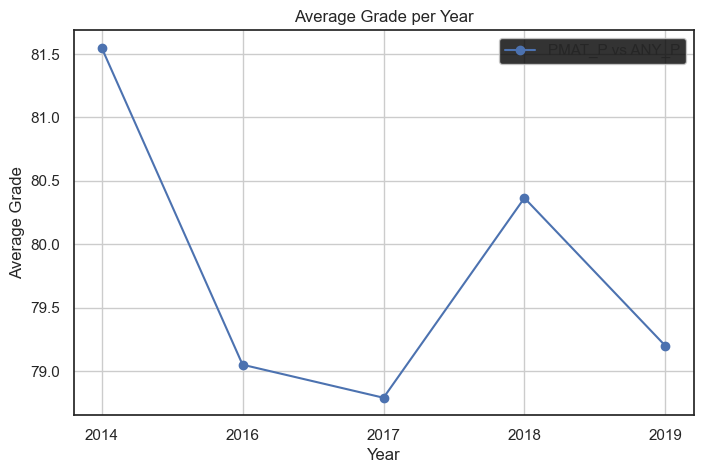

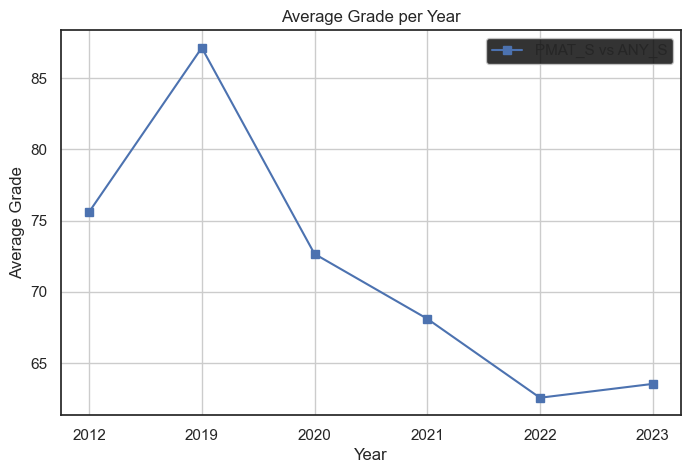

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Detectar totes les columnes de notes (comencen per "P")
note_cols_all = [c for c in df_merged.columns if c.startswith('P')]

# Per seguretat, assegurem que PMAT_P i PMAT_S hi siguin
print("Columnes de notes trobades:")
print(note_cols_all)

# 2) Convertir totes les notes a numèriques (coma → punt, string → float)
for col in note_cols_all:
    # Pas 1: assegurar tipus string
    s = df_merged[col].astype(str)
    # Pas 2: substituir comes per punts
    s = s.str.replace(',', '.', regex=False)
    # Pas 3: convertir a numèric, valors no convertibles → NaN
    df_merged[col] = pd.to_numeric(s, errors='coerce')


avg_pmatp_anyp = df_merged.groupby('ANY_P')['PMAT_P'].mean()
avg_pmats_anys = df_merged.groupby('ANY_S')['PMAT_S'].mean()

plt.figure(figsize=(8,5))

# Plot first series
plt.plot(avg_pmatp_anyp.index, avg_pmatp_anyp.values, marker='o', linestyle='-', label='PMAT_P vs ANY_P')

# Labels and title
plt.xlabel('Year')
plt.ylabel('Average Grade')
plt.title('Average Grade per Year')
plt.legend()
plt.grid(True)

plt.show()

plt.figure(figsize=(8,5))

# Plot second series
plt.plot(avg_pmats_anys.index, avg_pmats_anys.values, marker='s', linestyle='-', label='PMAT_S vs ANY_S')

# Labels and title
plt.xlabel('Year')
plt.ylabel('Average Grade')
plt.title('Average Grade per Year')
plt.legend()
plt.grid(True)

plt.show()


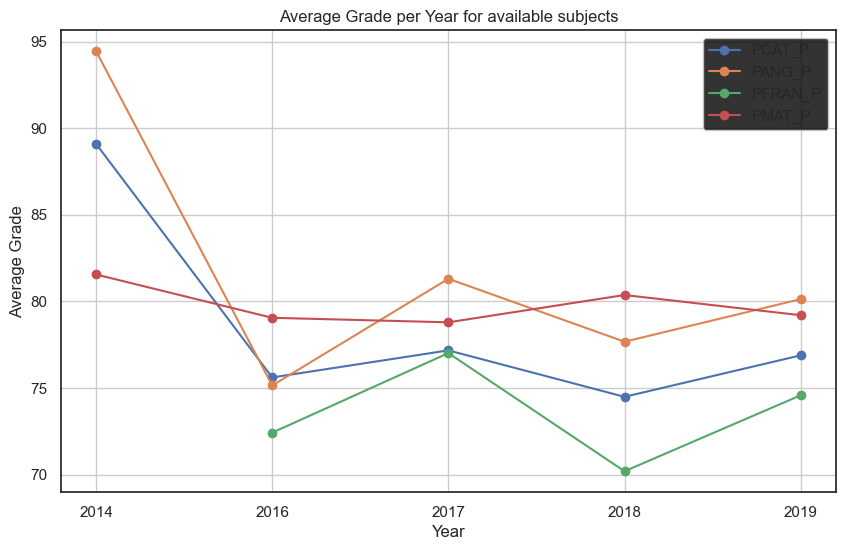

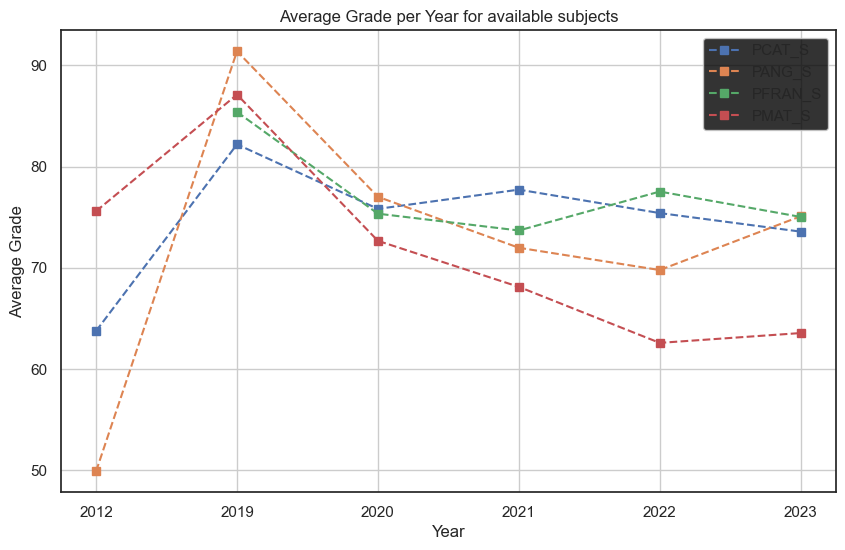

In [15]:
import matplotlib.pyplot as plt

assign = ['PCAT', 'PANG', 'PFRAN', 'PMAT', 'PALE', 'PCIEN']

plt.figure(figsize=(10,6))
for subject in assign:
    # Plot _P only if the column exists
    col_P = f'{subject}_P'
    if col_P in df_merged.columns:
        avg_P = df_merged.groupby('ANY_P')[col_P].mean()
        plt.plot(avg_P.index, avg_P.values, marker='o', linestyle='-', label=col_P)
    
# Labels, title, legend
plt.xlabel('Year')
plt.ylabel('Average Grade')
plt.title('Average Grade per Year for available subjects')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10,6))
for subject in assign:
    # Plot _S only if the column exists
    col_S = f'{subject}_S'
    if col_S in df_merged.columns:
        avg_S = df_merged.groupby('ANY_S')[col_S].mean()
        plt.plot(avg_S.index, avg_S.values, marker='s', linestyle='--', label=col_S)

# Labels, title, legend
plt.xlabel('Year')
plt.ylabel('Average Grade')
plt.title('Average Grade per Year for available subjects')
plt.legend()
plt.grid(True)
plt.show()

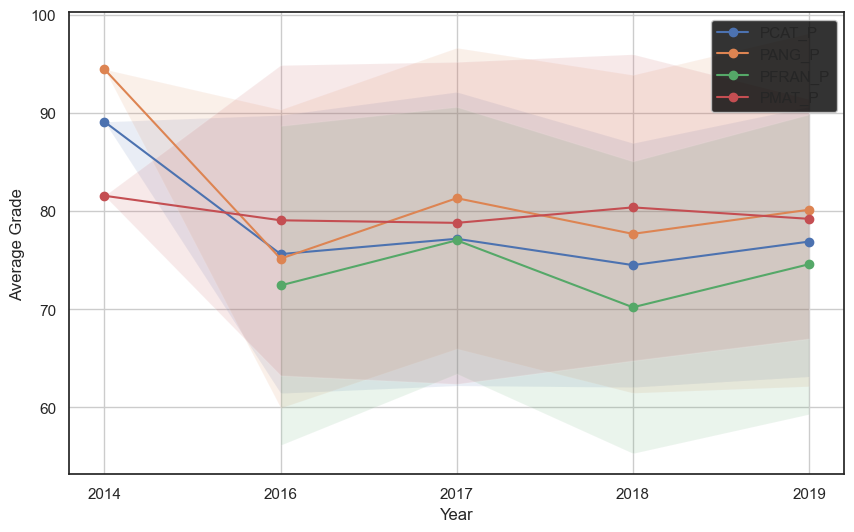

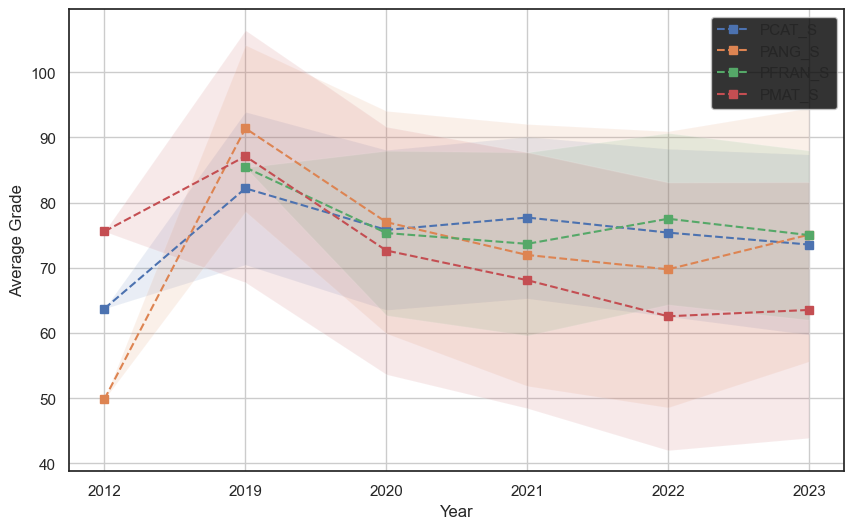

In [16]:
import matplotlib.pyplot as plt

assign = ['PCAT', 'PANG', 'PFRAN', 'PMAT', 'PALE', 'PCIEN']
suffixes = {'_P': 'ANY_P', '_S': 'ANY_S'}

for suffix, year_col in suffixes.items():
    plt.figure(figsize=(10,6))
    
    for subject in assign:
        col = f'{subject}{suffix}'
        if col in df_merged.columns:
            # Compute mean and std per year
            stats = df_merged.groupby(year_col)[col].agg(['mean', 'std'])
            x = stats.index
            y = stats['mean']
            yerr = stats['std'].fillna(0)
            
            # Plot mean line
            marker = 'o' if suffix == '_P' else 's'
            linestyle = '-' if suffix == '_P' else '--'
            plt.plot(x, y, marker=marker, linestyle=linestyle, label=col)
            
            # Fill between for error
            # Mask to avoid NaNs
            mask = ~(np.isnan(y) | np.isnan(yerr))
            plt.fill_between(x[mask], y[mask]-yerr[mask], y[mask]+yerr[mask], alpha=0.12)
    
    plt.xlabel('Year')
    plt.ylabel('Average Grade')
    # plt.title(f'Average Grade per Year with Error ({suffix})')
    plt.legend()
    plt.grid(True)
    plt.savefig('time_series_{}'.format(suffix))
    plt.show()


In [17]:
# Check all column names
print(df_merged.columns) 

# Check the first few rows and column names/data types
print(df_merged.head()) 

# Check the DataFrame information
print(df_merged.info())

Index(['ANY_P', 'CODI_ALUMNE', 'PCAT_P', 'PCAT_CL_P', 'PCAT_EE_P', 'PCAST_P',
       'PCAST_CL_P', 'PCAST_EE_P', 'PMAT_P', 'PMAT_NC_P', 'PMAT_EFM_P',
       'PMAT_CR_P', 'PANG_P', 'PANG_CO_P', 'PANG_CE', 'PFRAN_P', 'PFRAN_CO_P',
       'PFRAN_CE', 'PANG_EE_P', 'PFRAN_EE_P', 'PCAT_CO', 'PCAST_CO', 'PMED',
       'PMED_COMP1', 'PMED_COMP2', 'PMED_COMP3', 'GENERE_P', 'MES_NAIXEMENT_P',
       'ANY_NAIXEMENT_P', 'AREA_TERRITORIAL', 'NATURALESA_P', 'HÀBITAT_P',
       'ANY_S', 'PCAT_S', 'PCAT_CL_S', 'PCAT_EE_S', 'PCAST_S', 'PCAST_CL_S',
       'PCAST_EE_S', 'PANG_S', 'PANG_CO_S', 'PANG_CL', 'PANG_EE_S', 'PFRAN_S',
       'PFRAN_CO_S', 'PFRAN_CL', 'PFRAN_EE_S', 'PMAT_S', 'PMAT_EFM_S',
       'PMAT_CR_S', 'PMAT_EST', 'PMAT_NC_S', 'PALE', 'PALE_CO', 'PALE_CL',
       'PALE_EE', 'PCIEN', 'PCIEN_COMP1', 'PCIEN_COMP2', 'PCIEN_COMP3',
       'PCIEN_COMP4', 'GENERE_S', 'MES_NAIXEMENT_S', 'ANY_NAIXEMENT_S',
       'NATURALESA_S', 'ÀREA TERRITORIAL', 'HÀBITAT_S'],
      dtype='object', name=0)
0 ANY_

c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: 

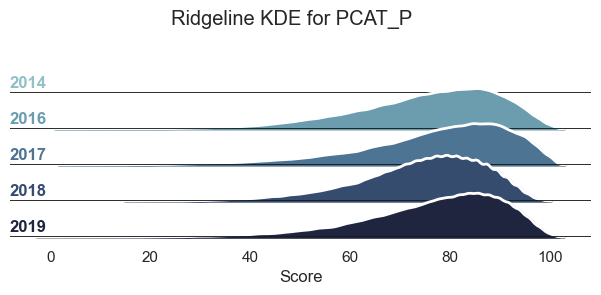

c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: 

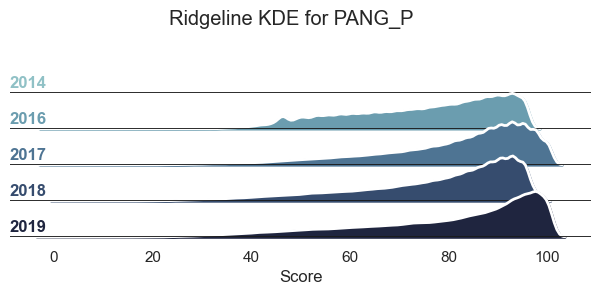

c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


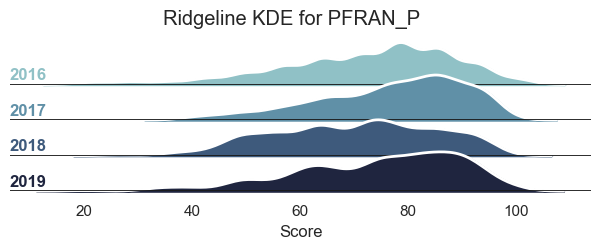

c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: 

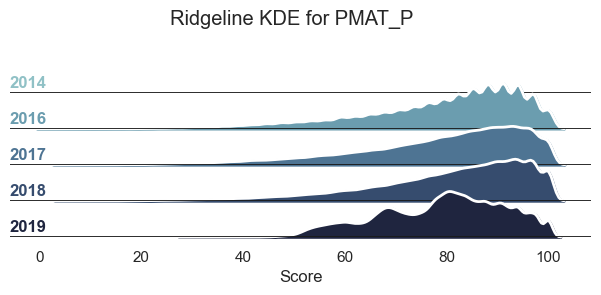

c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: 

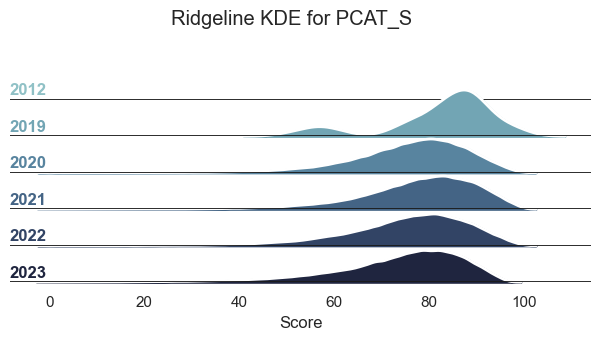

c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: 

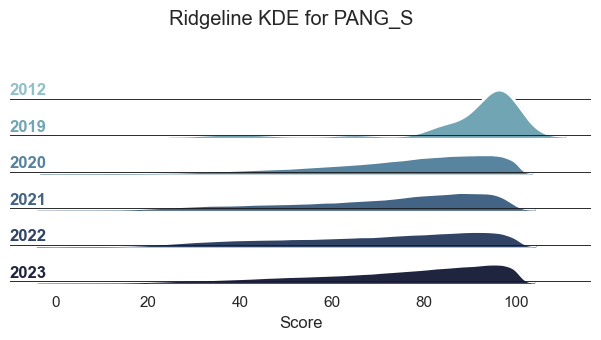

c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: 

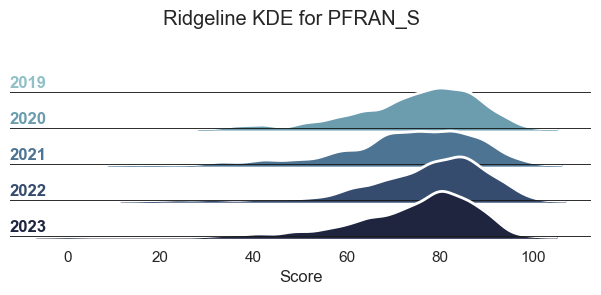

c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: 

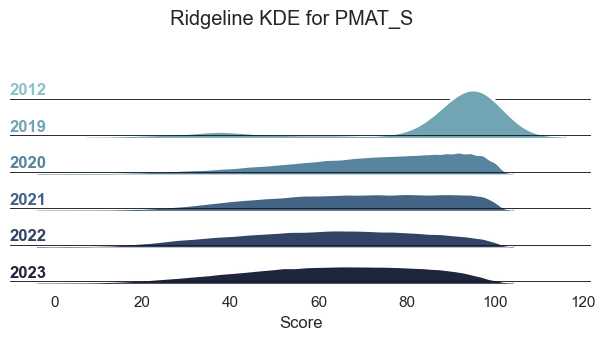

In [20]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd

# sns.set_theme(style='white', rc={'axes.facecolor': (0,0,0,0)})

# assign = ['PCAT', 'PANG', 'PFRAN', 'PMAT', 'PALE', 'PCIEN']
# suffixes = {'_P': 'ANY_P', '_S': 'ANY_S'}

# for suffix, year_col in suffixes.items():

#     # --------------------------------------------
#     # Prepare data for ridgeline plot
#     # Gather all subjects for this suffix in long format
#     # --------------------------------------------
#     cols = [f"{sub}{suffix}" for sub in assign if f"{sub}{suffix}" in df_merged.columns]

#     long_df = df_merged.melt(
#         id_vars=[year_col],
#         value_vars=cols,
#         var_name="Subject",
#         value_name="Score"
#     )

#     # Convert year to ordered category
#     long_df[year_col] = long_df[year_col].astype(str)
#     sorted_years = sorted(long_df[year_col].unique())
#     long_df[year_col] = (
#         long_df[year_col]
#         .astype("category")
#         .cat.set_categories(sorted_years, ordered=True)
#     )

#     # --------------------------------------------
#     # Create the ridgeline plot
#     # --------------------------------------------
#     pal = sns.cubehelix_palette(len(sorted_years), rot=-.25, light=.7)

#     g = sns.FacetGrid(
#         long_df,
#         row=year_col,
#         hue=year_col,
#         aspect=15,
#         height=.5,
#         palette=pal,
#         row_order=sorted_years
#     )

#     # KDE filled
#     g.map(
#         sns.kdeplot,
#         "Score",
#         bw_adjust=.5,
#         clip_on=False,
#         fill=True,
#         alpha=1,
#         linewidth=1.5
#     )

#     # KDE outline
#     g.map(
#         sns.kdeplot,
#         "Score",
#         clip_on=False,
#         color="w",
#         lw=2,
#         bw_adjust=.5
#     )

#     # Baseline
#     try:
#         g.refline(y=0, linewidth=2, linestyle="-", color=None)
#     except AttributeError:
#         for ax in g.axes.flatten():
#             ax.axhline(0, linewidth=2, linestyle="-", color="w")

#     # Label function
#     def label(x, color, **kwargs):
#         ax = plt.gca()
#         label_text = kwargs.get("label", "")  # year label
#         ax.text(
#             0, .2, label_text,
#             fontweight="bold",
#             color=color,
#             ha="left",
#             va="center",
#             transform=ax.transAxes
#         )

#     g.map(label, "Score")

#     # Cleanup
#     g.figure.subplots_adjust(hspace=-.25)
#     g.set_titles("")
#     g.set(yticks=[], ylabel="")
#     g.despine(bottom=True, left=True)

#     # Title + save
#     plt.suptitle(f"Ridgeline KDE for suffix {suffix}", y=1.02)
#     plt.savefig(f"ridgeplot_{suffix}.png", bbox_inches="tight")
#     plt.show()

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_theme(style='white', rc={'axes.facecolor': (0,0,0,0)})

assign = ['PCAT', 'PANG', 'PFRAN', 'PMAT', 'PALE', 'PCIEN']
suffixes = {'_P': 'ANY_P', '_S': 'ANY_S'}

for suffix, year_col in suffixes.items():
    for subject in assign:

        col = f"{subject}{suffix}"
        if col not in df_merged.columns:
            continue
        
        # ------------------------------------------------
        # Prepare subject data
        # ------------------------------------------------
        sub_df = df_merged[[year_col, col]].copy()
        sub_df.rename(columns={col: "Score"}, inplace=True)

        # Remove NaNs entirely
        sub_df = sub_df.dropna(subset=["Score", year_col])

        if sub_df.empty:
            continue  # subject has no valid data at all

        # Filter years with no valid observations
        valid_years = (
            sub_df.groupby(year_col)["Score"]
            .apply(lambda x: x.notna().any())
        )

        valid_years = valid_years[valid_years].index.tolist()

        # Keep only valid years
        sub_df = sub_df[sub_df[year_col].isin(valid_years)]

        if sub_df.empty:
            continue

        # Sort years as ordered category
        sub_df[year_col] = sub_df[year_col].astype(str)
        sorted_years = sorted(valid_years)
        sub_df[year_col] = (
            sub_df[year_col]
            .astype("category")
            .cat.set_categories(sorted_years, ordered=True)
        )

        # ------------------------------------------------
        # Ridgeline plot
        # ------------------------------------------------
        pal = sns.cubehelix_palette(len(sorted_years), rot=-.25, light=.7)

        g = sns.FacetGrid(
            sub_df,
            row=year_col,
            hue=year_col,
            aspect=15,
            height=.5,
            palette=pal,
            row_order=sorted_years
        )

        # Filled KDE
        g.map(
            sns.kdeplot,
            "Score",
            bw_adjust=.6,
            clip_on=False,
            fill=True,
            alpha=1,
            linewidth=1.5
        )

        # Outline
        g.map(
            sns.kdeplot,
            "Score",
            clip_on=False,
            color="w",
            lw=2,
            bw_adjust=.6
        )

        # Baseline
        for ax in g.axes.flatten():
            ax.axhline(0, lw=1.3, color="k")

        # Year label on each ridge
        def label(x, color, **kwargs):
            ax = plt.gca()
            label_text = kwargs.get("label", "")
            ax.text(
                0, .2, label_text,
                fontweight="bold",
                color=color,
                ha="left", va="center",
                transform=ax.transAxes
            )

        g.map(label, "Score")

        # Clean plot
        g.figure.subplots_adjust(hspace=-0.25)
        g.set_titles("")
        g.set(yticks=[], ylabel="")
        g.despine(bottom=True, left=True)

        plt.suptitle(f"Ridgeline KDE for {subject}{suffix}", y=1.02)
        plt.show()


c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: 

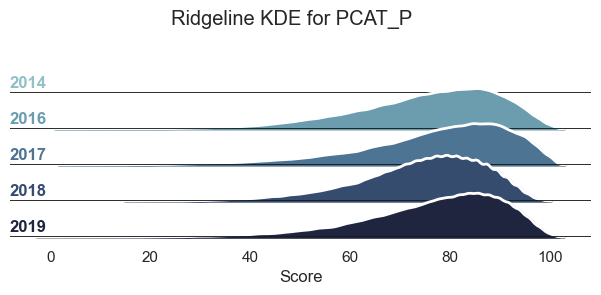

c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: 

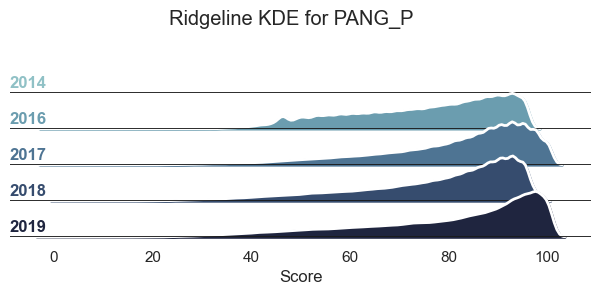

c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


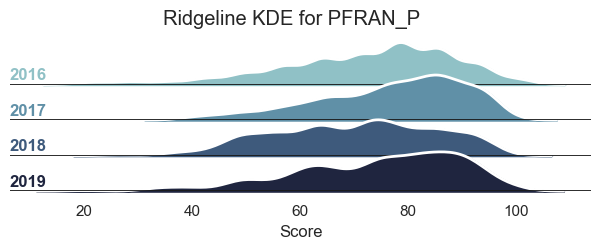

c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: 

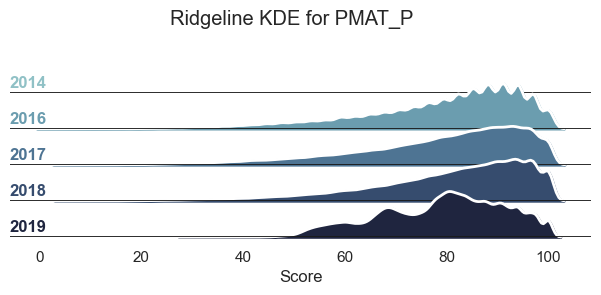

c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: 

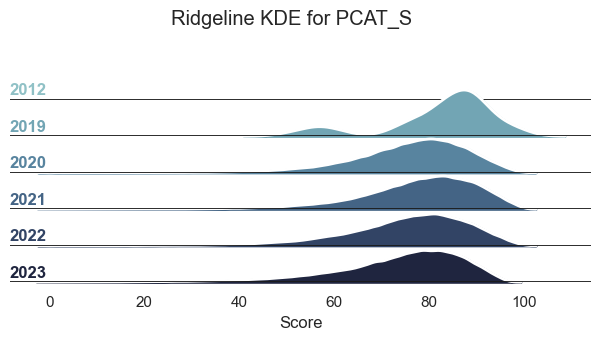

c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: 

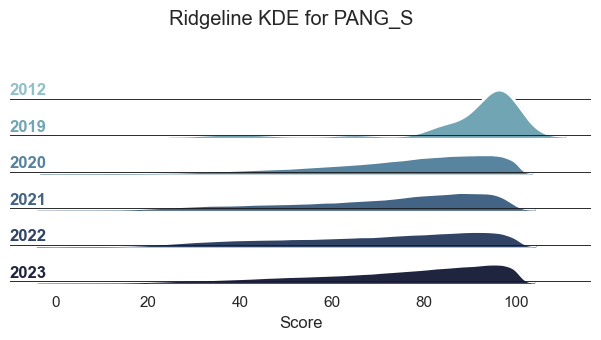

c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: 

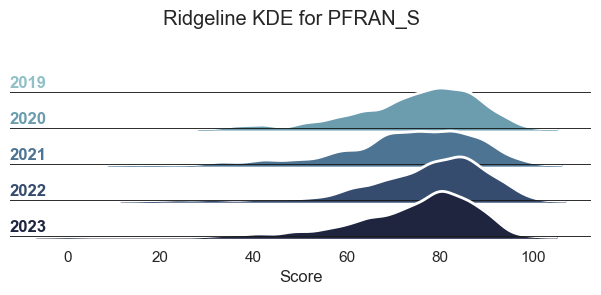

c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
c:\Users\ADRIÁN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: 

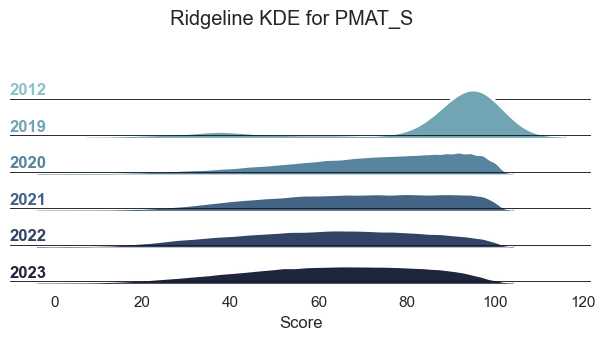

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd

# sns.set_theme(style='white', rc={'axes.facecolor': (0,0,0,0)})

# assign = ['PCAT', 'PANG', 'PFRAN', 'PMAT', 'PALE', 'PCIEN']
# suffixes = {'_P': 'ANY_P', '_S': 'ANY_S'}

# for suffix, year_col in suffixes.items():
#     for subject in assign:
        
#         col = f"{subject}{suffix}"
#         if col not in df_merged.columns:
#             continue
        
#         # ------------------------------------------------
#         # Prepare data: one subject, one suffix
#         # ------------------------------------------------
#         sub_df = df_merged[[year_col, col]].copy()
#         sub_df.rename(columns={col: "Score"}, inplace=True)
        
#         # Convert to ordered categorical years
#         sub_df[year_col] = sub_df[year_col].astype(str)
#         sorted_years = sorted(sub_df[year_col].unique())
#         sub_df[year_col] = (
#             sub_df[year_col]
#             .astype("category")
#             .cat.set_categories(sorted_years, ordered=True)
#         )
        
#         # ------------------------------------------------
#         # Ridgeline plot
#         # ------------------------------------------------
#         pal = sns.cubehelix_palette(len(sorted_years), rot=-.25, light=.7)
        
#         g = sns.FacetGrid(
#             sub_df,
#             row=year_col,
#             hue=year_col,
#             aspect=15,
#             height=.5,
#             row_order=sorted_years,
#             palette=pal
#         )
        
#         # Filled KDE
#         g.map(
#             sns.kdeplot,
#             "Score",
#             bw_adjust=.6,
#             clip_on=False,
#             fill=True,
#             alpha=1,
#             linewidth=1.5
#         )
        
#         # White outline
#         g.map(
#             sns.kdeplot,
#             "Score",
#             clip_on=False,
#             color="w",
#             lw=2,
#             bw_adjust=.6
#         )
        
#         # Baseline
#         for ax in g.axes.flatten():
#             ax.axhline(0, lw=1.3, color="k")
        
#         # Label the year on each ridge
#         def label(x, color, **kwargs):
#             ax = plt.gca()
#             label_text = kwargs.get("label", "")
#             ax.text(
#                 0, .2, label_text,
#                 fontweight="bold",
#                 color=color,
#                 ha="left",
#                 va="center",
#                 transform=ax.transAxes
#             )
        
#         g.map(label, "Score")
        
#         # Clean aesthetics
#         g.figure.subplots_adjust(hspace=-0.25)
#         g.set_titles("")
#         g.set(yticks=[], ylabel="")
#         g.despine(bottom=True, left=True)
        
#         # Title
#         plt.suptitle(f"Ridgeline KDE for {subject}{suffix}", y=1.02)
        # plt.show()

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_theme(style='white', rc={'axes.facecolor': (0,0,0,0)})

assign = ['PCAT', 'PANG', 'PFRAN', 'PMAT', 'PALE', 'PCIEN']
suffixes = {'_P': 'ANY_P', '_S': 'ANY_S'}

for suffix, year_col in suffixes.items():
    for subject in assign:

        col = f"{subject}{suffix}"
        if col not in df_merged.columns:
            continue
        
        # ------------------------------------------------
        # Prepare subject data
        # ------------------------------------------------
        sub_df = df_merged[[year_col, col]].copy()
        sub_df.rename(columns={col: "Score"}, inplace=True)

        # Remove rows with NaN score or NaN year
        sub_df = sub_df.dropna(subset=["Score", year_col])

        if sub_df.empty:
            continue   # nothing to plot at all

        # ------------------------------------------------
        # Remove years with no valid data
        # ------------------------------------------------
        # Count data per year
        counts = sub_df.groupby(year_col)["Score"].count()

        # Keep only years with >=1 observation
        valid_years = counts[counts > 0].index.tolist()

        # Filter DF
        sub_df = sub_df[sub_df[year_col].isin(valid_years)]

        if sub_df.empty:
            continue

        # ------------------------------------------------
        # Order valid years only (removes missing years entirely)
        # ------------------------------------------------
        sub_df[year_col] = sub_df[year_col].astype(str)
        sorted_years = sorted(valid_years)   # only years with data
        sub_df[year_col] = (
            sub_df[year_col]
            .astype("category")
            .cat.set_categories(sorted_years, ordered=True)
        )

        # ------------------------------------------------
        # Ridgeline plot
        # ------------------------------------------------
        pal = sns.cubehelix_palette(len(sorted_years), rot=-.25, light=.7)

        g = sns.FacetGrid(
            sub_df,
            row=year_col,
            hue=year_col,
            aspect=15,
            height=.5,
            palette=pal,
            row_order=sorted_years  # ensures only years with data appear
        )

        # Filled KDE
        g.map(
            sns.kdeplot,
            "Score",
            bw_adjust=.6,
            clip_on=False,
            fill=True,
            alpha=1,
            linewidth=1.5
        )

        # Outline
        g.map(
            sns.kdeplot,
            "Score",
            clip_on=False,
            color="w",
            lw=2,
            bw_adjust=.6
        )

        # Baseline
        for ax in g.axes.flatten():
            ax.axhline(0, lw=1.3, color="k")

        # Year label
        def label(x, color, **kwargs):
            ax = plt.gca()
            label_text = kwargs.get("label", "")
            ax.text(
                0, .2, label_text,
                fontweight="bold",
                color=color,
                ha="left", va="center",
                transform=ax.transAxes
            )

        g.map(label, "Score")

        # Clean plot
        g.figure.subplots_adjust(hspace=-0.25)
        g.set_titles("")
        g.set(yticks=[], ylabel="")
        g.despine(bottom=True, left=True)

        plt.suptitle(f"Ridgeline KDE for {subject}{suffix}", y=1.02)
        plt.show()

